In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from scipy.stats import spearmanr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM, GRU

(26304, 24)
       Atm Pressure   Temperature  ...    NOx_Target     CO_Traget
count  26304.000000  26304.000000  ...  26304.000000  26304.000000
mean     982.872928     25.296901  ...     92.176075   2342.513856
std        6.896038      8.298764  ...     96.524148   2065.708431
min      914.040000      4.060000  ...      2.910000     48.500000
25%      977.060000     18.867000  ...     31.675750   1250.000000
50%      982.797000     26.920000  ...     60.400000   1790.000000
75%      988.850000     31.367000  ...    115.000000   2690.000000
max      999.390000     44.400000  ...   1090.000000  38300.000000

[8 rows x 24 columns]


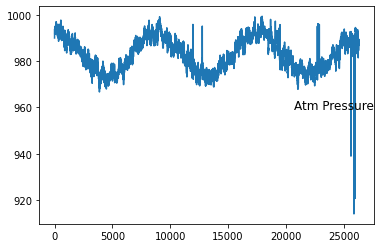

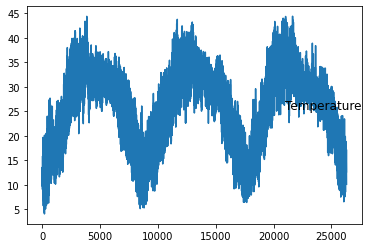

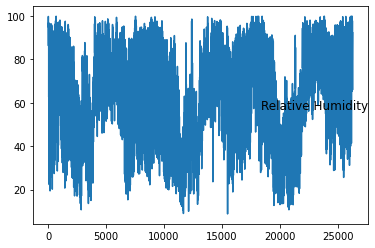

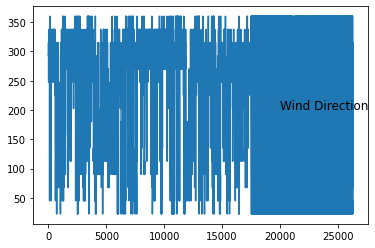

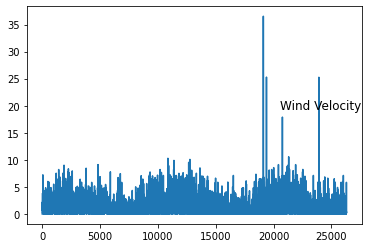

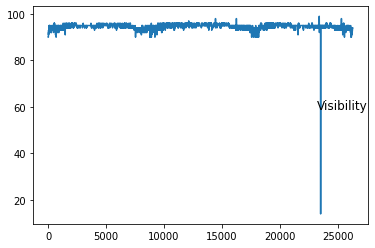

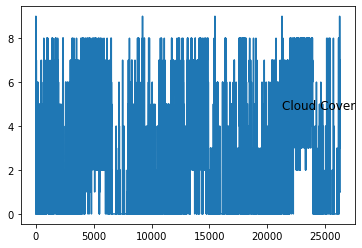

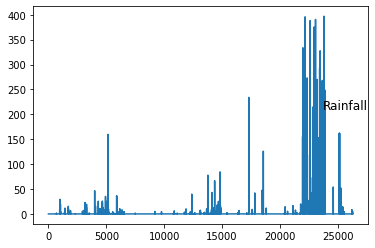

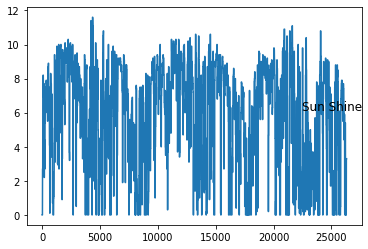

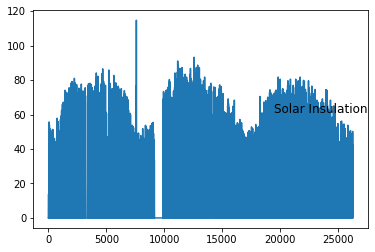

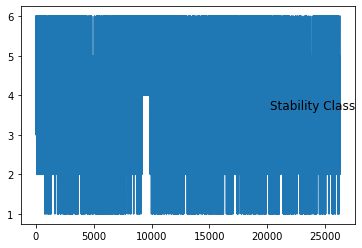

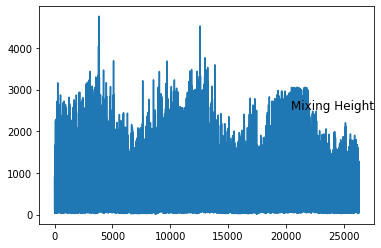

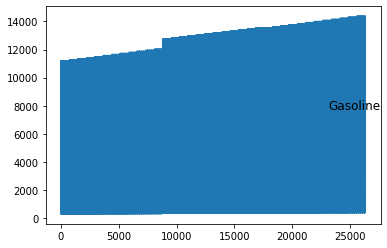

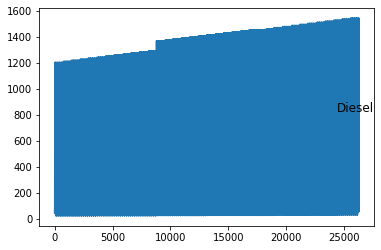

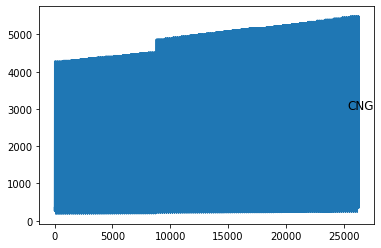

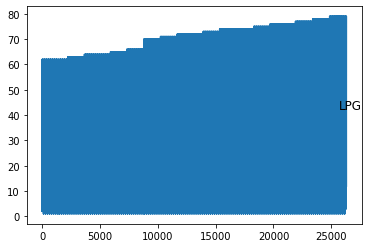

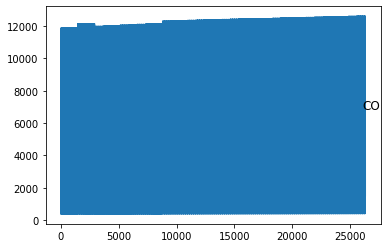

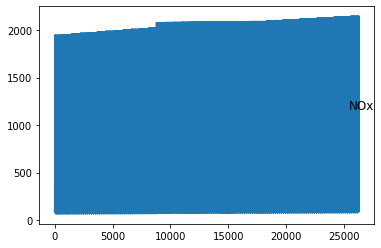

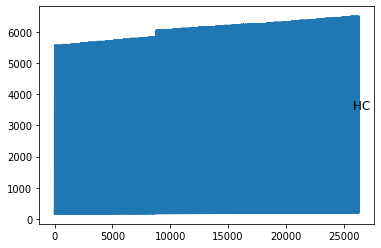

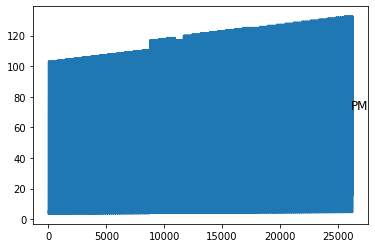

In [2]:
dataframe = read_csv('/content/drive/MyDrive/inno/data.csv', header=0, index_col=0)
print(dataframe.shape)
print(dataframe.describe())
dataset = dataframe.values
def ploter(groups):
  i = 1
  for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(dataset[:, group])
    pyplot.title(dataframe.columns[group], y=0.5, loc='right')
    i += 1
  pyplot.show()
for i in range(0,20):
    group = [i]
    ploter(group)

In [3]:
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[ 990.     ,    9.8    ,   95.     , ...,  229.     ,  147.     ,
        3840.     ],
       [ 990.435  ,   10.148  ,   95.87   , ...,  228.23685,  149.     ,
        3490.     ],
       [ 990.87   ,   10.496  ,   96.739  , ...,  227.47368,   92.1    ,
        2970.     ],
       ...,
       [ 988.823  ,   10.607  ,   91.133  , ...,  145.     ,   38.3    ,
         991.667  ],
       [ 989.19   ,   10.14   ,   91.8    , ...,  146.     ,   37.     ,
         923.333  ],
       [ 989.319  ,   10.106  ,   92.189  , ...,  141.     ,   56.7    ,
         855.     ]], dtype=float32)

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
data = np.concatenate((dataset[:,0:12], dataset[:,20:21]), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


(26304, 13)
(26303, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var12(t-1)  var13(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.024462    0.014060  0.895079
2   0.895079   0.150917   0.956813  ...    0.040261    0.013539  0.900175
3   0.900175   0.159544   0.966363  ...    0.057578    0.013594  0.906349
4   0.906349   0.162122   0.976923  ...    0.074738    0.013539  0.912982
5   0.912982   0.162122   0.987912  ...    0.091557    0.015019  0.919625

[5 rows x 14 columns]


In [6]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 13) (21042,) (5261, 1, 13) (5261,)


Epoch 1/73
281/281 - 3s - loss: 0.0813 - val_loss: 0.0877
Epoch 2/73
281/281 - 1s - loss: 0.0384 - val_loss: 0.0805
Epoch 3/73
281/281 - 1s - loss: 0.0357 - val_loss: 0.0730
Epoch 4/73
281/281 - 1s - loss: 0.0333 - val_loss: 0.0683
Epoch 5/73
281/281 - 1s - loss: 0.0308 - val_loss: 0.0636
Epoch 6/73
281/281 - 1s - loss: 0.0287 - val_loss: 0.0596
Epoch 7/73
281/281 - 1s - loss: 0.0274 - val_loss: 0.0555
Epoch 8/73
281/281 - 1s - loss: 0.0254 - val_loss: 0.0530
Epoch 9/73
281/281 - 1s - loss: 0.0241 - val_loss: 0.0507
Epoch 10/73
281/281 - 1s - loss: 0.0231 - val_loss: 0.0494
Epoch 11/73
281/281 - 1s - loss: 0.0218 - val_loss: 0.0440
Epoch 12/73
281/281 - 1s - loss: 0.0202 - val_loss: 0.0377
Epoch 13/73
281/281 - 1s - loss: 0.0196 - val_loss: 0.0364
Epoch 14/73
281/281 - 1s - loss: 0.0185 - val_loss: 0.0345
Epoch 15/73
281/281 - 1s - loss: 0.0176 - val_loss: 0.0312
Epoch 16/73
281/281 - 1s - loss: 0.0166 - val_loss: 0.0279
Epoch 17/73
281/281 - 1s - loss: 0.0160 - val_loss: 0.0234
Epoch 

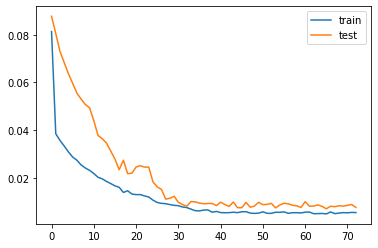

In [7]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=73, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.473
Test CC(Corelation Coefficient)     : 0.983
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.947


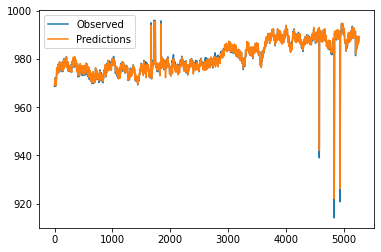

In [8]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [9]:
data = np.concatenate((dataset[:,0:12], dataset[:,21:22]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())


[[990.        9.8      95.      ...   6.      130.447   229.     ]
 [990.435    10.148    95.87    ...   6.      205.447   228.23685]
 [990.87     10.496    96.739   ...   5.      287.652   227.47368]
 ...
 [988.823    10.607    91.133   ...   6.       59.4     145.     ]
 [989.19     10.14     91.8     ...   6.       64.091   146.     ]
 [989.319    10.106    92.189   ...   6.       68.782   141.     ]]
(26303, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var12(t-1)  var13(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.024462    0.213692  0.895079
2   0.895079   0.150917   0.956813  ...    0.040261    0.212961  0.900175
3   0.900175   0.159544   0.966363  ...    0.057578    0.212230  0.906349
4   0.906349   0.162122   0.976923  ...    0.074738    0.211499  0.912982
5   0.912982   0.162122   0.987912  ...    0.091557    0.210768  0.919625

[5 rows x 14 columns]


In [10]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 13) (21042,) (5261, 1, 13) (5261,)


Epoch 1/72
264/264 - 2s - loss: 0.0843 - val_loss: 0.0998
Epoch 2/72
264/264 - 1s - loss: 0.0435 - val_loss: 0.0799
Epoch 3/72
264/264 - 1s - loss: 0.0395 - val_loss: 0.0675
Epoch 4/72
264/264 - 1s - loss: 0.0365 - val_loss: 0.0564
Epoch 5/72
264/264 - 1s - loss: 0.0332 - val_loss: 0.0534
Epoch 6/72
264/264 - 1s - loss: 0.0312 - val_loss: 0.0510
Epoch 7/72
264/264 - 1s - loss: 0.0295 - val_loss: 0.0492
Epoch 8/72
264/264 - 1s - loss: 0.0281 - val_loss: 0.0488
Epoch 9/72
264/264 - 1s - loss: 0.0270 - val_loss: 0.0480
Epoch 10/72
264/264 - 1s - loss: 0.0259 - val_loss: 0.0461
Epoch 11/72
264/264 - 1s - loss: 0.0246 - val_loss: 0.0445
Epoch 12/72
264/264 - 1s - loss: 0.0236 - val_loss: 0.0428
Epoch 13/72
264/264 - 1s - loss: 0.0226 - val_loss: 0.0418
Epoch 14/72
264/264 - 1s - loss: 0.0221 - val_loss: 0.0397
Epoch 15/72
264/264 - 1s - loss: 0.0214 - val_loss: 0.0381
Epoch 16/72
264/264 - 1s - loss: 0.0209 - val_loss: 0.0355
Epoch 17/72
264/264 - 1s - loss: 0.0203 - val_loss: 0.0359
Epoch 

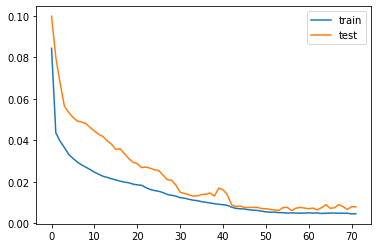

In [11]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=80, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.485
Test CC(Corelation Coefficient)     : 0.988
Test PB(Percentage Bias)            : 0.000
Test NSE(Nash Sutcliffe Efficiency) : 0.946


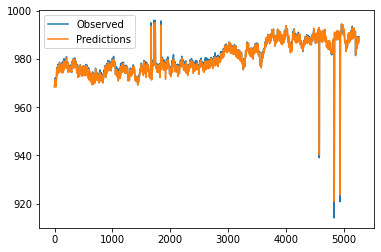

In [12]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [13]:
data = np.concatenate((dataset[:,0:12], dataset[:,22:23]), axis=1)
print(data)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())

[[990.      9.8    95.    ...   6.    130.447 147.   ]
 [990.435  10.148  95.87  ...   6.    205.447 149.   ]
 [990.87   10.496  96.739 ...   5.    287.652  92.1  ]
 ...
 [988.823  10.607  91.133 ...   6.     59.4    38.3  ]
 [989.19   10.14   91.8   ...   6.     64.091  37.   ]
 [989.319  10.106  92.189 ...   6.     68.782  56.7  ]]
(26303, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var12(t-1)  var13(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.024462    0.132547  0.895079
2   0.895079   0.150917   0.956813  ...    0.040261    0.134386  0.900175
3   0.900175   0.159544   0.966363  ...    0.057578    0.082045  0.906349
4   0.906349   0.162122   0.976923  ...    0.074738    0.073950  0.912982
5   0.912982   0.162122   0.987912  ...    0.091557    0.067051  0.919625

[5 rows x 14 columns]


In [14]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 13) (21042,) (5261, 1, 13) (5261,)


Epoch 1/72
121/121 - 2s - loss: 0.1544 - val_loss: 0.0675
Epoch 2/72
121/121 - 0s - loss: 0.0506 - val_loss: 0.0697
Epoch 3/72
121/121 - 0s - loss: 0.0609 - val_loss: 0.0733
Epoch 4/72
121/121 - 0s - loss: 0.0734 - val_loss: 0.0707
Epoch 5/72
121/121 - 0s - loss: 0.0810 - val_loss: 0.0650
Epoch 6/72
121/121 - 0s - loss: 0.0769 - val_loss: 0.0608
Epoch 7/72
121/121 - 0s - loss: 0.0699 - val_loss: 0.0580
Epoch 8/72
121/121 - 0s - loss: 0.0637 - val_loss: 0.0556
Epoch 9/72
121/121 - 0s - loss: 0.0591 - val_loss: 0.0527
Epoch 10/72
121/121 - 0s - loss: 0.0568 - val_loss: 0.0510
Epoch 11/72
121/121 - 0s - loss: 0.0544 - val_loss: 0.0492
Epoch 12/72
121/121 - 0s - loss: 0.0529 - val_loss: 0.0476
Epoch 13/72
121/121 - 0s - loss: 0.0510 - val_loss: 0.0458
Epoch 14/72
121/121 - 0s - loss: 0.0498 - val_loss: 0.0445
Epoch 15/72
121/121 - 0s - loss: 0.0486 - val_loss: 0.0433
Epoch 16/72
121/121 - 0s - loss: 0.0475 - val_loss: 0.0422
Epoch 17/72
121/121 - 0s - loss: 0.0466 - val_loss: 0.0413
Epoch 

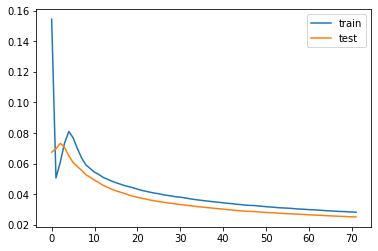

In [15]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=72, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 3.267
Test CC(Corelation Coefficient)     : 0.924
Test PB(Percentage Bias)            : -0.001
Test NSE(Nash Sutcliffe Efficiency) : 0.741


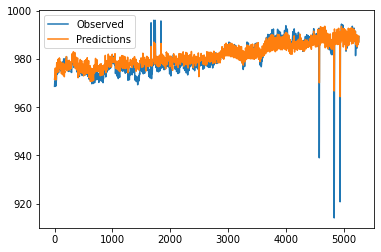

In [16]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)

valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()

In [17]:
z =  dataset[:,23]
z = z.reshape(z.shape[0],1)
data = np.concatenate((dataset[:,0:12],z), axis=1)
print(data.shape)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
reframed = series_to_supervised(data, 1, 1)
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())

(26304, 13)
(26303, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var12(t-1)  var13(t-1)   var1(t)
1   0.889982   0.142291   0.947253  ...    0.024462    0.099120  0.895079
2   0.895079   0.150917   0.956813  ...    0.040261    0.089970  0.900175
3   0.900175   0.159544   0.966363  ...    0.057578    0.076376  0.906349
4   0.906349   0.162122   0.976923  ...    0.074738    0.071932  0.912982
5   0.912982   0.162122   0.987912  ...    0.091557    0.064612  0.919625

[5 rows x 14 columns]


In [18]:
values = reframed.values
n_train_hours = int((reframed.shape[0])*(0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21042, 1, 13) (21042,) (5261, 1, 13) (5261,)


Epoch 1/69
222/222 - 2s - loss: 0.1096 - val_loss: 0.0841
Epoch 2/69
222/222 - 0s - loss: 0.0452 - val_loss: 0.0740
Epoch 3/69
222/222 - 0s - loss: 0.0427 - val_loss: 0.0685
Epoch 4/69
222/222 - 0s - loss: 0.0407 - val_loss: 0.0648
Epoch 5/69
222/222 - 0s - loss: 0.0387 - val_loss: 0.0618
Epoch 6/69
222/222 - 0s - loss: 0.0370 - val_loss: 0.0594
Epoch 7/69
222/222 - 0s - loss: 0.0357 - val_loss: 0.0573
Epoch 8/69
222/222 - 0s - loss: 0.0345 - val_loss: 0.0554
Epoch 9/69
222/222 - 0s - loss: 0.0335 - val_loss: 0.0537
Epoch 10/69
222/222 - 0s - loss: 0.0325 - val_loss: 0.0523
Epoch 11/69
222/222 - 0s - loss: 0.0317 - val_loss: 0.0509
Epoch 12/69
222/222 - 0s - loss: 0.0309 - val_loss: 0.0497
Epoch 13/69
222/222 - 0s - loss: 0.0302 - val_loss: 0.0486
Epoch 14/69
222/222 - 0s - loss: 0.0296 - val_loss: 0.0475
Epoch 15/69
222/222 - 0s - loss: 0.0290 - val_loss: 0.0466
Epoch 16/69
222/222 - 0s - loss: 0.0284 - val_loss: 0.0456
Epoch 17/69
222/222 - 0s - loss: 0.0279 - val_loss: 0.0446
Epoch 

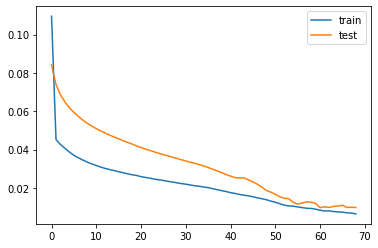

In [19]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=69, batch_size=95, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Test RMSE(Root Mean Squared Error)  : 1.625
Test CC(Corelation Coefficient)     : 0.982
Test PB(Percentage Bias)            : 0.001
Test NSE(Nash Sutcliffe Efficiency) : 0.936


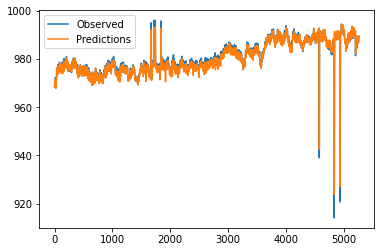

In [20]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE(Root Mean Squared Error)  : %.3f' % rmse)
cc = spearmanr(inv_y, inv_yhat);
print('Test CC(Corelation Coefficient)     : %.3f' % cc.correlation)
xpb, xob, num, den = 0, 0, 0, 0
for y in inv_yhat:
  xpb += y
xpb = xpb/len(inv_yhat)
for y in inv_y:
  xob += y
  num += y - xpb
  den += y
xob = xob/len(inv_y)
pb = num/den
print('Test PB(Percentage Bias)            : %.3f' % pb)
num, den = 0, 0
for i in range(0, len(inv_y)):
  num += ((inv_y[i] - inv_yhat[i])*(inv_y[i] - inv_yhat[i]))
  den += ((inv_y[i] - xob)*(inv_y[i] - xob))
nse = abs(1 - (num/den))
print('Test NSE(Nash Sutcliffe Efficiency) : %.3f' % nse)
valid = pd.DataFrame()
valid = valid.assign(Observed = inv_y)
valid = valid.assign(Predictions = inv_yhat)
gr = valid[['Observed', 'Predictions']]
gr.plot()
pyplot.show()